In [1]:
# imports 
import emp_preprocessing as ep
import emp_fake_data as ef
import emp_metrics as em
import networkx as nx
import functions as fct
import numpy as np
import pandas as pd
import parameters as par
import os
import graphics as gx
import data_mapping as dm

import cpnet
import networkx as nx
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from tqdm import tqdm

#-----------
# parameters
path = "./results/empirical_results/test_3/"
plot_period=250

#------------------
# source files path

# from USB key
path_mmsr_secured = r'D:\MMSR_secured_small.dta'
path_mmsr_unsecured= r'D:\Unsecured_deposits_Small.dta'
path_finrep = r'D:\FINREP_Small.dta'

# # from NA laptop
# path_mmsr_secured = r'P:\ECB business areas\DGR\Databases and Programme files\FIR\Nolwenn Allaire\ABM - Le Coz\data\mmsr_all/MMSR_secured_small.dta'
# path_mmsr_unsecured= r'P:\ECB business areas\DGR\Databases and Programme files\FIR\Nolwenn Allaire\ABM - Le Coz\data\mmsr_all/Unsecured_deposits_Small.dta'
# path_finrep = r'P:\ECB business areas\DGR\Databases and Programme files\FIR\Nolwenn Allaire\ABM - Le Coz\results\Model Inputs\2. Bank Balance Sheet Statistics\balance_sheet_data_clean.dta'

# 1 data preprocessing

## 1.1  load input data

In [ ]:
# get df_mmsr secured (used for transaction and exposure view)
df_mmsr_secured = pd.read_stata(path_mmsr_secured)
df_mmsr_secured.rename(columns=dm.dic_mmsr_secured_columns, inplace=True) # change the columns names 

# get df_mmsr unsecured (used for deposits time series)
df_mmsr_unsecured = pd.read_stata(path_mmsr_unsecured)

# build fake finrep data (used for accounting view)
df_finrep = pd.read_stata(path_finrep)
df_finrep.rename(columns=dm.dic_finrep_columns, inplace=True) # change the columns names 

## 1.2 build fake data

In [ ]:
# nb_lines = int(1e2)

# # opt 2: get df_mmsr secured (used for transaction and exposure view)
# df_mmsr_secured = ef.get_df_mmsr_secured(nb_tran=nb_lines,holidays=dm.holidays)

# # get df_mmsr unsecured (used for deposits time series)
# df_mmsr_unsecured = ef.get_df_mmsr_unsecured(nb_tran=nb_lines,holidays=dm.holidays)

# # build fake finrep data (used for accounting view)
# df_finrep = ef.get_df_finrep()

## 1.3 preprocessing

In [ ]:
# to reload without re-anonymization
# df_mmsr_secured.drop(columns = ["tenor", "end_step","start_step", "evergreen"], inplace=True)

In [ ]:
# data anonymization
df_mmsr_secured, df_mmsr_unsecured, df_finrep = ep.anonymize(df_mmsr_secured,df_mmsr_unsecured,df_finrep, path=path)

# data size reduction
ep.reduce_size(df_mmsr_secured,df_mmsr_unsecured, path)

# get dic reverse repo exp adj history directly from mmsr
df_mmsr_secured, df_mmsr_secured_clean = ep.get_df_mmsr_secured_clean(df_mmsr_secured, path=path, compute_tenor=True, flag_isin=True, sett_filter=True)
df_mmsr_secured_expanded = ep.get_df_mmsr_secured_expanded(df_mmsr_secured_clean,  holidays=False, path=path)
dic_rev_repo_exp_adj = ep.get_dic_rev_repo_exp_adj_from_df_mmsr_secured_expanded(df_mmsr_secured_expanded,path=path, plot_period=False)

# get aggregated adjency matrices
dic_arr_binary_adj = ep.get_dic_arr_binary_adj(dic_rev_repo_exp_adj=dic_rev_repo_exp_adj,path=path, plot_period=plot_period)

# get df_rev_repo_trans
df_rev_repo_trans = ep.get_df_rev_repo_trans(df_mmsr_secured_clean, path=path)

# get dic dashed trajectory 
df_finrep_clean = ep.get_df_finrep_clean(df_finrep, path=path)
ep.add_ratios_in_df_finrep_clean(df_finrep_clean, path=path)
dic_dashed_trajectory = ep.get_dic_dashed_trajectory(df_finrep_clean,path=path)

In [ ]:
df_mmsr_secured_clean["evergreen"].value_counts(dropna=False)/len(df_mmsr_secured_clean)

False    0.718824
True     0.281176
Name: evergreen, dtype: float64

## 1.4 pickle

In [ ]:
# imports 
import emp_preprocessing as ep
import emp_fake_data as ef
import emp_metrics as em
import networkx as nx
import functions as fct
import numpy as np
import pandas as pd
import parameters as par
import os
import graphics as gx
import data_mapping as dm

import cpnet
import networkx as nx
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from tqdm import tqdm

#-----------
# parameters
path = "./results/empirical_results/test_3/"
plot_period=250

# load input data
df_mmsr_secured, df_mmsr_secured_clean, df_mmsr_secured_expanded, df_mmsr_unsecured, df_finrep_clean = ep.load_input_data_pickle(path=path)

# pickle (faster)
dic_arr_binary_adj = ep.load_dic_arr_binary_adj(path=path)
dic_rev_repo_exp_adj = ep.load_dic_rev_repo_exp_adj(path=path)
dic_dashed_trajectory = ep.load_dic_dashed_trajectory(path=path)
df_rev_repo_trans = pd.read_csv(f"{path}pickle/df_rev_repo_trans.csv", index_col=0)

# 2 metrics measurement

In [ ]:
os.makedirs(f"{path}accounting_view/", exist_ok=True)

### 2.1.2 accounting items

#### A - static, distribution across banks, at several point in time 

In [ ]:
days = list(dic_rev_repo_exp_adj.keys())
plot_days = fct.list_intersection(days, dic_dashed_trajectory.keys())
bank_items = list(list(dic_dashed_trajectory.values())[0].columns)

# get df_powerlaw
df_powerlaw = em.get_powerlaw(
            dic_dashed_trajectory=dic_dashed_trajectory,
            days=days,
            plot_days=plot_days,
            plot_period=plot_period,
            path=f"{path}accounting_view/static/"
        )

# plot each powerlaw charts 
gx.plot_powerlaw(
            df_network_trajectory=df_powerlaw,
            days=days,
            plot_period=plot_period,
            path=f"{path}accounting_view/",
            plot_days=plot_days,
            bank_items=bank_items,
        )

# plot p-values across time 
gx.plot_network_trajectory(
                df=df_powerlaw,
                cols=[f"powerlaw p-value {bank_item}"  for bank_item in bank_items],
                file_name=f"{path}accounting_view/static/powerlaw_pvalue.pdf",
            )

# plot alpha of power laws across time 
gx.plot_network_trajectory(
                df=df_powerlaw,
                cols=[f"powerlaw alpha {bank_item}"  for bank_item in bank_items],
                file_name=f"{path}accounting_view/static/powerlaw_alpha.pdf",
            )

#### B - dynamic, distribution across time

In [ ]:
df_delta_deposits, df_relative_deposits, df_delta_deposits_over_assets = em.get_df_deposits(df_mmsr_unsecured, dic_dashed_trajectory)

get df_deposits


In [ ]:
# distribution of deposits relative variation across time for each single bank
df_deposits_variations_by_bank = em.get_df_deposits_variations_by_bank(df_delta_deposits, df_relative_deposits, df_delta_deposits_over_assets, f"{path}/accounting_view/dynamic/")

df = df_deposits_variations_by_bank[df_deposits_variations_by_bank>0]
em.run_n_plot_powerlaw(df,f"{path}accounting_view/dynamic/per_bank/positive/", transverse=True)

df = -df_deposits_variations_by_bank[df_deposits_variations_by_bank<0]
em.run_n_plot_powerlaw(df,f"{path}accounting_view/dynamic/per_bank/negative/", transverse=True)

#### C - mixed view across time and banks

In [ ]:
# distribution of deposits relative variation across time for each single bank
df_deposits_variations = em.get_df_deposits_variations(df_delta_deposits, df_relative_deposits, df_delta_deposits_over_assets, f"{path}/accounting_view/mixed/")

df = df_deposits_variations[df_deposits_variations>0]
em.run_n_plot_powerlaw(df,f"{path}accounting_view/mixed/positive/")

df = -df_deposits_variations[df_deposits_variations<0]
em.run_n_plot_powerlaw(df,f"{path}accounting_view/mixed/negative/")

## 2.2. exposure view

In [ ]:
os.makedirs(f"{path}exposure_view/", exist_ok=True)

### 2.2.1 jaccard

In [ ]:
days = list(dic_rev_repo_exp_adj.keys())

# get jaccard
df_jaccard = em.get_rev_repo_exposure_stats(dic_arr_binary_adj, days, path=f"{path}exposure_view/")
gx.plot_network_trajectory(
            df=df_jaccard,
            cols=df_jaccard.columns,
            file_name=f"{path}exposure_view/jaccard_index.pdf")

get jaccard


100%|██████████| 2548/2548 [00:00<00:00, 2990.20it/s]


### 2.2.2 density

In [ ]:
days = list(dic_rev_repo_exp_adj.keys())

# get density
df_density = em.get_density(dic_arr_binary_adj, days, path=f"{path}exposure_view/")
gx.plot_network_trajectory(
            df=df_density,
            cols=df_density.columns,
            file_name=f"{path}exposure_view/network_density.pdf",
        )

get density


100%|██████████| 2548/2548 [00:00<00:00, 2856.61it/s]


### 2.2.3 degree distribution  (static)

In [ ]:
days = list(dic_rev_repo_exp_adj.keys())

# get degree distribution
dic_in_degree, dic_out_degree, dic_degree = em.get_degree_distribution(dic_arr_binary_adj, path=f"{path}exposure_view/degree_distribution/")
gx.plot_degree_distribution(dic_in_degree,
    dic_out_degree,
    days,
    plot_period,
    f"{path}exposure_view/degree_distribution/")


get degree distribution


100%|██████████| 2549/2549 [00:10<00:00, 243.40it/s]


### 2.2.4 degree stats

In [ ]:
days = list(dic_rev_repo_exp_adj.keys())

# get av. degree
df_degree_stats = em.get_degree_stats(dic_degree, days, path=f"{path}exposure_view/")
gx.plot_network_trajectory(
            df=df_degree_stats,
            cols=df_degree_stats.columns,
            file_name=f"{path}exposure_view/degree_stats.pdf",
        )

get degree stats


100%|██████████| 2548/2548 [00:01<00:00, 1340.62it/s]


### 2.2.5 degree per asset

In [ ]:
days = list(dic_rev_repo_exp_adj.keys())
bank_ids = list(dic_rev_repo_exp_adj.values())[0].index

# select the days and banks (common between the 2 lists)
finrep_days = list(df_finrep_clean["qdate"])
finrep_bank_ids = list(set(df_finrep_clean["report_agent_lei"]))
plot_days = fct.list_intersection(days, finrep_days)

# plot
gx.plot_degree_per_asset(
    dic_dashed_trajectory,
    dic_degree,
    bank_ids,
    days,
    plot_period,
    f"{path}exposure_view/degree_per_asset/",
    plot_days=plot_days,
    finrep_bank_ids=finrep_bank_ids)

### 2.2.6 network plots (static)

In [ ]:
days = list(dic_rev_repo_exp_adj.keys())
bank_ids = list(list(dic_rev_repo_exp_adj.values())[0].index)
arr_rev_repo_exp_adj = ep.convert_dic_to_array(dic_rev_repo_exp_adj)
plot_days = fct.list_intersection(days, dic_dashed_trajectory.keys())

# plot the reverse repo network
gx.plot_weighted_adj_network(
    arr_rev_repo_exp_adj,
    dic_dashed_trajectory,
    days,
    plot_period,
    f"{path}exposure_view/weighted_adj_network/",
    "reverse repo",
    bank_ids=bank_ids,
    plot_days=plot_days,
)

### 2.2.6 core periphery (static)

In [ ]:
arr_rev_repo_exp_adj = ep.convert_dic_to_array(dic_rev_repo_exp_adj)
days = list(dic_rev_repo_exp_adj.keys())

# get df_cpnet
df_cpnet = em.get_cpnet(
                dic_arr_binary_adj=dic_arr_binary_adj,
                arr_rev_repo_exp_adj=arr_rev_repo_exp_adj,
                days=days,
                plot_period=plot_period,
                path=f"{path}exposure_view/core-periphery/",
            )

# Plot the core-periphery struture
gx.plot_cpnet(
                df_network_trajectory=df_cpnet,
                dic_arr_binary_adj=dic_arr_binary_adj,
                arr_rev_repo_exp_adj=arr_rev_repo_exp_adj,
                days=days,
                plot_period=plot_period,
                path=f"{path}exposure_view/",
            )

# # read csv (faster)
# df_cpnet = pd.read_csv(f"{path}exposure_view/core-periphery/df_cpnet.csv", index_col=0)
# df_cpnet.index = pd.to_datetime(df_cpnet.index)

# plot the time evolution of p-values for each aggregation level
for fig in par.figs_cpnet_pvalues:
    gx.plot_network_trajectory(
            df=df_cpnet,
            cols=fig[1],
            file_name=f"{path}{fig[0]}.pdf",
        )

## 2.3 transaction view

In [ ]:
os.makedirs(f"{path}transaction_view/", exist_ok=True)

### 2.3.1 av network

In [ ]:
days = list(dic_rev_repo_exp_adj.keys())
df_transaction_stats = em.get_transaction_stats(
            df_rev_repo_trans=df_rev_repo_trans,
            extension=" av. network",
            days=days,
            path=f"{path}transaction_view/",
        )

# plot the time evolution of the av network trans level metrics
for fig in [par.fig_repo_transactions_maturity_av_network, par.fig_repo_transactions_notional_av_network, par.fig_number_repo_transactions_av_network]:
    gx.plot_network_trajectory(
            df=df_transaction_stats,
            cols=fig[1],
            file_name=f"{path}{fig[0]}.pdf",
        )

get transaction stats av. network


100%|██████████| 2548/2548 [00:21<00:00, 120.40it/s]


### 2.3.2 reverse repos by notice period (static)

#### A - Static

In [ ]:
# plot notional by notice period
gx.plot_notional_by_notice_period(df_mmsr_secured_expanded, path=f"{path}transaction_view/", plot_period=plot_period)

#### A - Dynamic 

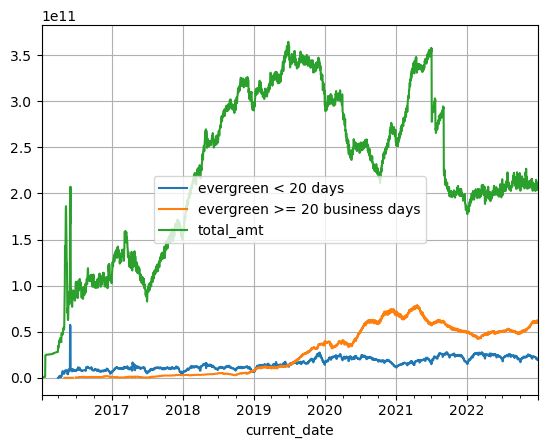

In [ ]:
# plot the total amount of repo by tenor and type
df = df_mmsr_secured_expanded[["current_date","tenor","evergreen","trns_nominal_amt"]][df_mmsr_secured_expanded["evergreen"]]
df["evergreen >= 20 days"] = df["tenor"] >= 20
df = df.groupby(["evergreen >= 20 days","current_date"]).agg({"trns_nominal_amt":sum}).unstack(level="evergreen >= 20 days")
df = df.droplevel(0,axis=1)
df.columns.name = None
df.rename(columns={True:"evergreen >= 20 business days",False:"evergreen < 20 days"}, inplace=True)
ax = df.plot()
df_mmsr_secured_expanded.groupby(["current_date"]).agg(
    total_amt=("trns_nominal_amt",sum)).plot(ax=ax)
plt.grid()


### 2.3.3 colletral ising code reuse

#### A - Static

In [ ]:
df_isin = em.get_df_isin(df_mmsr_secured_expanded, path=f"{path}transaction_view/")
gx.plot_collateral_reuse(df_isin=df_isin, path=f"{path}transaction_view/", plot_period=plot_period)

#### B - Dynamic

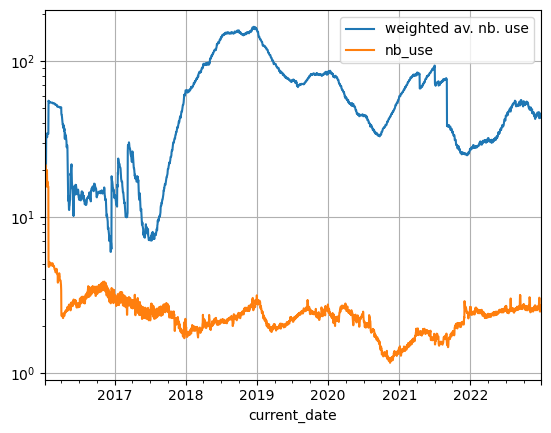

In [ ]:
df = df_isin[["nb_use","total_amt"]]
df["prod_nb_use"] = df["nb_use"]*df["total_amt"]
df_grouped = df.groupby(["current_date"]).agg({"prod_nb_use":sum,"total_amt":sum, "nb_use":"mean"})
df_grouped["weighted av. nb. use"] = df_grouped["prod_nb_use"] / df_grouped["total_amt"]
df_grouped[["weighted av. nb. use", "nb_use"]].plot()
plt.yscale("log")
plt.grid()

<Axes: xlabel='nb_use', ylabel='total_amt'>

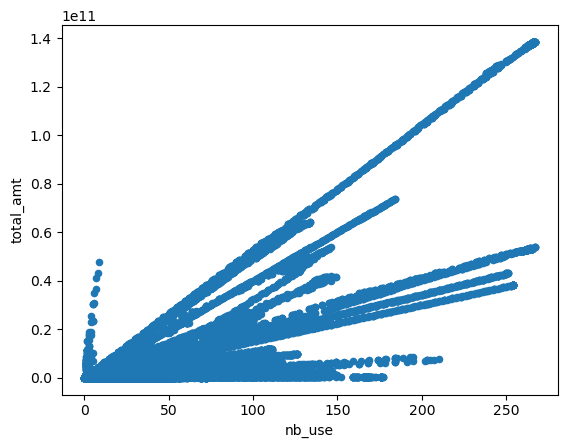

In [ ]:
df_isin.plot.scatter(x="nb_use", y="total_amt")

In [ ]:
df_isin.reset_index().groupby(["nb_use"]).agg({"coll_isin":tuple}).tail(50)

,coll_isin
nb_use,
218,"(ES0352506176, ES0352506135, ES0352506176, ES0..."
219,"(ES0352506176, ES0352506135, ES0352506234, XS0..."
220,"(ES0352506176, ES0352506176, ES0352506176, ES0..."
221,"(ES0352506176, ES0352506135, ES0352506135, ES0..."
222,"(ES0352506176, ES0352506135, ES0352506135, ES0..."
223,"(ES0352506176, ES0352506135, ES0352506176, ES0..."
224,"(ES0352506176, ES0352506135, ES0352506234, ES0..."
225,"(ES0352506176, ES0352506176, ES0352506176, ES0..."
226,"(ES0352506176, ES0352506135, ES0352506135, ES0..."


In [ ]:
df_isin.sort_values("nb_use",ascending=False)

nb_use     total_amt  \
current_date coll_isin                            
2018-11-30   ES0352506176     267  1.384031e+11   
2019-12-17   ES0352506234     267  5.378748e+10   
2019-12-18   ES0352506234     267  5.378748e+10   
2018-11-12   ES0352506176     267  1.384364e+11   
2018-11-26   ES0352506176     267  1.384031e+11   
...                           ...           ...   
2017-08-14   GB00B39J2M42       0  0.000000e+00   
             GB00BD6K4575       0  0.000000e+00   
2020-08-09   ES0157097017       0  0.000000e+00   
             ES0167050915       0  0.000000e+00   
2021-04-19   US28618M1062       0  0.000000e+00   

                                                                      tp_amt  
current_date coll_isin                                                        
2018-11-30   ES0352506176  (499999946.67, 528462471.38, 528462471.38, 528...  
2019-12-17   ES0352506234  (499992119.12, 499999946.67, 184852276.49, 184...  
2019-12-18   ES0352506234  (499992119.12, 499999946.67, 184852276.49, 184...  
2018-11-12   ES0352506176  (499999946.67, 528462471.38, 528462471.38, 528...  
2018-11-26   ES0352506176  (499999946.67, 528462471.38, 528462471.38, 528...  
...                                                                      ...  
2017-08-14   GB00B39J2M42                                             (nan,)  
             GB00BD6K4575                                             (nan,)  
2020-08-09   ES0157097017                                             (nan,)  
             ES0167050915                                             (nan,)  
2021-04-19   US28618M1062                                         (nan, nan)  

[5272934 rows x 3 columns]

In [ ]:
df_isin

nb_use    total_amt  \
current_date coll_isin                           
2016-01-08   DE000A1ZZ028      23   30077180.0   
             XS0490739686      20  193853640.0   
2016-01-09   DE000A1ZZ028      23   30077180.0   
             XS0490739686      20  193853640.0   
2016-01-10   DE000A1ZZ028      23   30077180.0   
...                           ...          ...   
2022-12-30   XS2555198089       2    1740375.0   
             XS2555209381       1     803728.0   
             XS2555218291       1    1487740.0   
             XS2558592932       2    1921760.0   
             XS2559453431       1    2714040.0   

                                                                      tp_amt  
current_date coll_isin                                                        
2016-01-08   DE000A1ZZ028  (1292221.0, 1292221.0, 1292221.0, 1292221.0, 1...  
             XS0490739686  (5325000.0, 9922560.0, 9922560.0, 9922560.0, 9...  
2016-01-09   DE000A1ZZ028  (1292221.0, 1292221.0, 1292221.0, 1292221.0, 1...  
             XS0490739686  (5325000.0, 9922560.0, 9922560.0, 9922560.0, 9...  
2016-01-10   DE000A1ZZ028  (1292221.0, 1292221.0, 1292221.0, 1292221.0, 1...  
...                                                                      ...  
2022-12-30   XS2555198089                               (870187.5, 870187.5)  
             XS2555209381                                        (803728.0,)  
             XS2555218291                                       (1487740.0,)  
             XS2558592932                              (507200.0, 1414560.0)  
             XS2559453431                                       (2714040.0,)  

[5272934 rows x 3 columns]

<Axes: xlabel='current_date'>

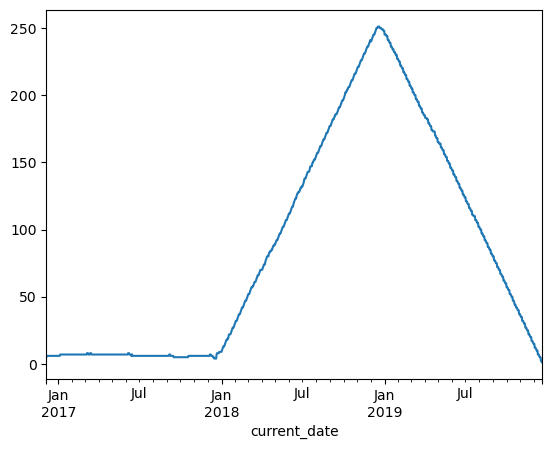

In [ ]:
df_isin.loc[:,"ES0352506135",:]["nb_use"].plot()

In [ ]:
test = df_mmsr_secured_clean[df_mmsr_secured_clean["coll_isin"]=="ES0352506135"]
test["line_id"] = test.index
test_grouped = test.groupby([
            "report_agent_lei",
            "cntp_lei",
            "tenor",
            "trns_nominal_amt",
            "coll_isin",
            "start_step",

        ]).agg({"line_id":tuple,"evergreen":tuple})

C:\Users\VictorLeCoz\AppData\Local\Temp\ipykernel_17796\1858524862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["line_id"] = test.index


In [ ]:
test_grouped.head(50)

line_id  \
report_agent_lei cntp_lei tenor trns_nominal_amt coll_isin    start_step               
282              12766    130.0 4.500720e+08     ES0352506135 4332.0        (47815,)   
                          272.0 4.500720e+08     ES0352506135 4332.0        (47837,)   
                 13947    48.0  9.827922e+07     ES0352506135 4557.0       (399437,)   
                          82.0  7.314605e+07     ES0352506135 4602.0       (415107,)   
5088             3587     258.0 2.632844e+08     ES0352506135 4602.0       (415204,)   
                 11555    271.0 1.715375e+08     ES0352506135 4602.0       (190330,)   
                 12766    49.0  4.940408e+08     ES0352506135 4355.0       (227920,)   
                          65.0  4.900670e+08     ES0352506135 4402.0       (227908,)   
                          67.0  3.827977e+08     ES0352506135 4531.0       (227903,)   
                                4.881320e+08     ES0352506135 4466.0       (227926,)   
                          68.0  8.159250e+07     ES0352506135 4736.0       (444309,)   
6319             6371     7.0   1.000068e+08     ES0352506135 4723.0       (460248,)   
                                1.000262e+08     ES0352506135 4718.0       (460234,)   
6371             6319     7.0   1.000068e+08     ES0352506135 4723.0       (495521,)   
                                1.000262e+08     ES0352506135 4718.0       (494722,)   
7969             9787     168.0 4.998500e+07     ES0352506135 4674.0       (484183,)   
9787             7969     1.0   3.998800e+07     ES0352506135 4794.0      (1106222,)   
                                4.998500e+07     ES0352506135 4713.0      (1106224,)   
                                9.997000e+07     ES0352506135 4676.0      (1106228,)   
                          2.0   9.997000e+07     ES0352506135 4674.0       (430197,)   
                          3.0   3.998800e+07     ES0352506135 4818.0       (430211,)   
                          193.0 9.977000e+07     ES0352506135 4482.0       (209096,)   
11555            5088     1.0   1.715375e+08     ES0352506135 4618.0       (472091,)   
                                                              4680.0       (485584,)   
                                                              4745.0       (499170,)   
                                                              4748.0       (499656,)   
                          256.0 1.715375e+08     ES0352506135 4602.0       (415194,)   
                                                              4605.0       (416256,)   
                                                              4609.0       (470020,)   
                                                              4614.0       (471164,)   
                                                              4619.0       (472428,)   
                                                              4624.0       (473538,)   
                                                              4629.0       (474644,)   
                                                              4634.0       (475578,)   
                                                              4639.0       (476460,)   
                                                              4644.0       (477304,)   
                                                              4649.0       (478343,)   
                                                              4654.0       (479302,)   
                                                              4659.0       (480463,)   
                                                              4664.0       (481517,)   
                                                              4687.0       (487229,)   
                                                              4691.0       (489036,)   
                                                              4696.0       (490121,)   
                                                              4701.0       (491339,)   
                             

# 3 tools

## 3.1 examples of density / histogram in log - log

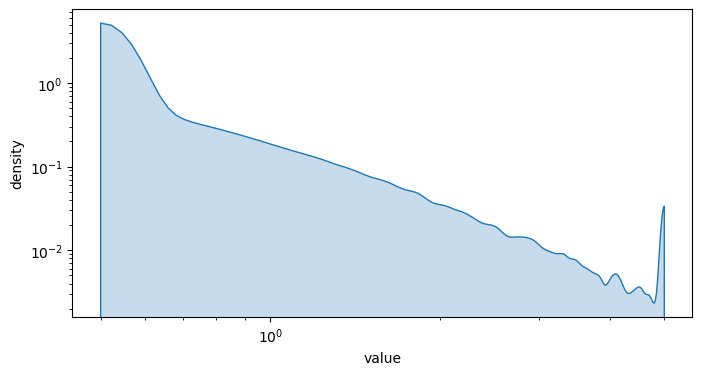

In [ ]:
# Pareto law

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate random data
x = np.random.pareto(3,size=100000)

# Compute the absolute value and sign of the data
abs_x = np.abs(x)
sign_x = np.sign(x)

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the KDE on a log scale with the transformed data
sns.kdeplot(x.clip(0.5,5), ax=ax, cut=0, fill=True)
ax.set_xscale('log')

# Set the y-axis to log scale
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('value')
ax.set_ylabel('density')

# Show the plot
plt.show()

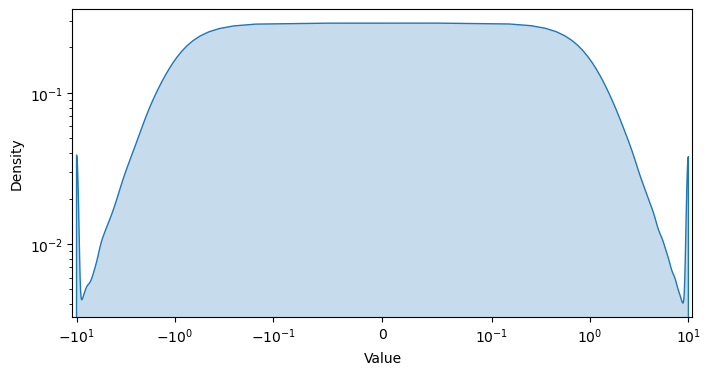

In [ ]:
# student law

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate random data
x = np.random.standard_t(1,size=100000)

# Compute the absolute value and sign of the data
abs_x = np.abs(x)
sign_x = np.sign(x)

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the KDE on a log scale with the transformed data
sns.kdeplot(x.clip(-10,10), ax=ax, fill=True, cut=0)
ax.set_xscale('symlog', linthresh=0.1)

# Set the y-axis to log scale
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('Value')
ax.set_ylabel('Density')

# Show the plot
plt.show()

## 3.2 multiple histogram on the same plot

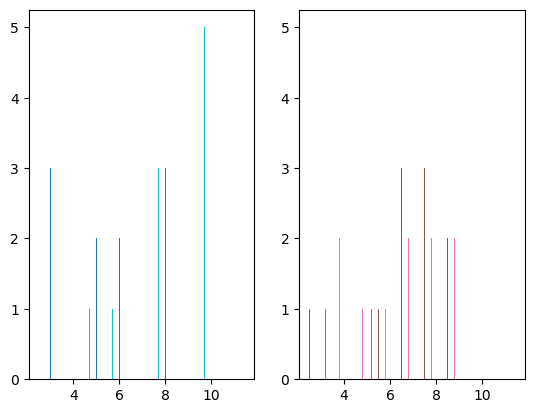

In [ ]:
from matplotlib import pyplot as plt

fig, (ax1,ax2) = plt.subplots(1,2)
pos = 0
width = 0.2
for  i in range(10):
    binary_adj = np.random.randint(0,2,(10,10))
    bank_network = nx.from_numpy_array(
                binary_adj,
                parallel_edges=False,
                create_using=nx.DiGraph,
            )  # first define a networkx object.
    ar_in_degree = np.array(bank_network.in_degree())[:,1]
    hist = np.unique(ar_in_degree, return_counts=True)
    ax1.bar(hist[0] + pos, hist[1], width=0.01)
    ax2.bar(hist[0] + pos, hist[1], width=0.01)
    pos = pos +width +0.1



## 3.3 power low fitting

Calculating best minimal value for power law fit
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


4.569572170812804
1.6323330459866918


<Axes: >

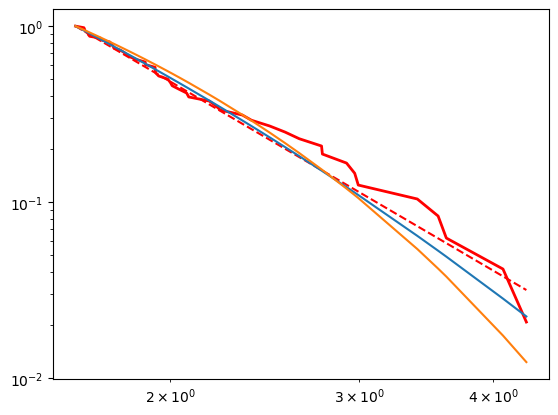

In [ ]:
# fitting
import powerlaw
import numpy as np
sr_data = np.random.pareto(3,size=1000) # data can be list or numpy array
powerlaw_fit = powerlaw.Fit(sr_data)
print(powerlaw_fit.power_law.alpha)
print(powerlaw_fit.power_law.xmin)
R, p = powerlaw_fit.distribution_compare('power_law', 'exponential')
fig2 = powerlaw_fit.plot_ccdf(color = "r", linewidth = 2)
powerlaw_fit.power_law.plot_ccdf(color = "r", linestyle = "--", ax = fig2)
powerlaw_fit.lognormal.plot_ccdf(ax=fig2)
powerlaw_fit.exponential.plot_ccdf(ax=fig2)

## 3.4 build the calendar

In [ ]:
from workalendar.europe import EuropeanCentralBank

# build the list of holidays
holidays = []
for year in range(2000,2025):
    holidays = holidays + EuropeanCentralBank().holidays(year)

# reformating into a list
holidays = [tuple_day[0] for tuple_day in holidays]
holidays

[datetime.date(2000, 1, 1),
 datetime.date(2000, 4, 21),
 datetime.date(2000, 4, 24),
 datetime.date(2000, 5, 1),
 datetime.date(2000, 12, 25),
 datetime.date(2000, 12, 26),
 datetime.date(2001, 1, 1),
 datetime.date(2001, 4, 13),
 datetime.date(2001, 4, 16),
 datetime.date(2001, 5, 1),
 datetime.date(2001, 12, 25),
 datetime.date(2001, 12, 26),
 datetime.date(2002, 1, 1),
 datetime.date(2002, 3, 29),
 datetime.date(2002, 4, 1),
 datetime.date(2002, 5, 1),
 datetime.date(2002, 12, 25),
 datetime.date(2002, 12, 26),
 datetime.date(2003, 1, 1),
 datetime.date(2003, 4, 18),
 datetime.date(2003, 4, 21),
 datetime.date(2003, 5, 1),
 datetime.date(2003, 12, 25),
 datetime.date(2003, 12, 26),
 datetime.date(2004, 1, 1),
 datetime.date(2004, 4, 9),
 datetime.date(2004, 4, 12),
 datetime.date(2004, 5, 1),
 datetime.date(2004, 12, 25),
 datetime.date(2004, 12, 26),
 datetime.date(2005, 1, 1),
 datetime.date(2005, 3, 25),
 datetime.date(2005, 3, 28),
 datetime.date(2005, 5, 1),
 datetime.date(200

## 3.4 quality check on the cleaning of mmsr from evergreens

In [ ]:
def get_len(row):
    if isinstance(row["trans_id"], int):
        return 1 
    else:
        return len(row["trans_id"])


apply_func = lambda row: get_len(row)
df_rev_repo_trans["len"] = df_rev_repo_trans.apply(apply_func, axis=1)
df_rev_repo_trans[["len"]].value_counts()

## 3.1 analysis of the accuracy of the reporting in MMSR

In [ ]:
df_mmsr_secured["evergreen"].value_counts()/len(df_mmsr_secured["evergreen"])

True     0.99295
False    0.00705
Name: evergreen, dtype: float64

In [ ]:
len(df_mmsr_secured[df_mmsr_secured["evergreen"]])

7687072

In [ ]:
df = df_mmsr_secured.groupby(["report_agent_lei","cntp_lei","trns_nominal_amt","maturity_band"]).agg({"trade_date":lambda x: list(x),"maturity_date":lambda x: list(x)})

In [ ]:
df["len"]>1

report_agent_lei  cntp_lei  trns_nominal_amt  maturity_band
528               1307      3.006900e+07      Up to 1M         False
                            4.285000e+07      Up to 1M         False
                            4.874880e+07      Up to 1M         False
                            4.908000e+07      Up to 1M         False
                            5.007000e+07      Up to 1M         False
                                                               ...  
14701             13504     1.501984e+09      S/N              False
                  14347     1.049209e+07      O/N               True
                                              Up to 1W          True
                            2.017169e+07      O/N               True
                                              Up to 1W          True
Name: len, Length: 777129, dtype: bool

In [ ]:
df[df["len"]>100].loc[:,:,:,"Up to 1M"].iloc[-1]["trade_date"]

[Timestamp('2020-07-28 00:00:00'),
 Timestamp('2020-08-03 00:00:00'),
 Timestamp('2020-08-04 00:00:00'),
 Timestamp('2020-08-05 00:00:00'),
 Timestamp('2020-08-06 00:00:00'),
 Timestamp('2020-08-07 00:00:00'),
 Timestamp('2020-08-10 00:00:00'),
 Timestamp('2020-08-11 00:00:00'),
 Timestamp('2020-08-12 00:00:00'),
 Timestamp('2020-08-13 00:00:00'),
 Timestamp('2020-08-14 00:00:00'),
 Timestamp('2020-08-17 00:00:00'),
 Timestamp('2020-08-18 00:00:00'),
 Timestamp('2020-08-19 00:00:00'),
 Timestamp('2020-08-20 00:00:00'),
 Timestamp('2020-08-21 00:00:00'),
 Timestamp('2020-08-24 00:00:00'),
 Timestamp('2020-08-25 00:00:00'),
 Timestamp('2020-08-26 00:00:00'),
 Timestamp('2020-08-27 00:00:00'),
 Timestamp('2020-08-28 00:00:00'),
 Timestamp('2020-08-31 00:00:00'),
 Timestamp('2020-09-01 00:00:00'),
 Timestamp('2020-09-02 00:00:00'),
 Timestamp('2020-09-03 00:00:00'),
 Timestamp('2020-09-04 00:00:00'),
 Timestamp('2020-09-07 00:00:00'),
 Timestamp('2020-09-08 00:00:00'),
 Timestamp('2020-09-

In [ ]:
def get_len(row):
    if isinstance(row["trade_date"], int):
        return 1 
    else:
        return len(row["trade_date"])


apply_func = lambda row: get_len(row)
df["len"] = df.apply(apply_func, axis=1)
df[["len"]].value_counts()

len 
1       474235
2        55724
3        26553
4        25110
5        16559
         ...  
520          1
517          1
516          1
513          1
2385         1
Length: 585, dtype: int64

In [ ]:
df_mmsr_secured_clean = ep.get_df_mmsr_secured_clean(df_mmsr_secured,holidays=dm.holidays, path="./results/empirical_results/analysis_evergreen/", compute_tenor=True)
df_mmsr_secured_clean

get df_mmsr_secured_clean


,report_agent_lei,cntp_lei,list_start_steps,start_step,trns_nominal_amt,tenor,maturity_date,trade_date,trns_type,coll_isin
0,5884,528,NaN,100,5.000000e+05,12,2016-06-16,2016-05-31,False,XS1167154654
1,5884,528,NaN,100,5.000000e+05,11,2016-06-15,2016-05-31,False,XS0526326334
2,5884,528,NaN,82,1.000000e+06,5,2016-05-12,2016-05-05,False,XS1050916649
3,14701,528,NaN,88,1.404179e+08,1,2016-05-14,2016-05-13,False,XS1084050316
4,5884,528,NaN,86,3.915516e+06,2,2016-05-13,2016-05-11,False,CH0038863350
...,...,...,...,...,...,...,...,...,...,...
4050209,14701,14347,"[108, 110, 111, 112, 113, 115, 116, 117, 118]",110,1.049209e+07,4,2016-06-25,2016-06-10,True,DE000LBB38J9
4050210,14701,14347,"[108, 110, 111, 112, 113, 115, 116, 117, 118]",115,1.049209e+07,4,2016-06-25,2016-06-10,True,DE000LBB38J9
4050211,14701,14347,"[106, 107, 108, 110, 111, 112, 113, 115, 116, ...",106,2.017169e+07,3,2016-06-25,2016-06-08,True,DE000LBB5MG2
4050212,14701,14347,"[106, 107, 108, 110, 111, 112, 113, 115, 116, ...",110,2.017169e+07,4,2016-06-25,2016-06-08,True,DE000LBB5MG2


In [ ]:
# .loc[4050204,"trns_nominal_amt"]
df_mmsr_secured_clean.tail(50)

,report_agent_lei,cntp_lei,list_start_steps,start_step,trns_nominal_amt,tenor,maturity_date,trade_date,trns_type,coll_isin
4050164,14701,13504,[318],318,1.146000e+08,2,2017-04-05,2017-04-03,True,EU000A1GVJX6
4050165,14701,13504,[175],175,1.184600e+08,13,2016-09-30,2016-09-13,True,EU000A1GVJX6
4050166,14701,13504,[168],168,1.185200e+08,2,2016-09-06,2016-09-02,True,EU000A1GVJX6
4050167,14701,13504,[169],169,1.185400e+08,2,2016-09-07,2016-09-05,True,EU000A1GVJX6
4050168,14701,13504,[166],166,1.185500e+08,3,2016-09-05,2016-08-31,True,EU000A1GVJX6
4050169,14701,13504,[206],206,1.332625e+08,2,2016-10-28,2016-10-26,True,DE000A1MLVD8
4050170,14701,13504,[350],350,1.340375e+08,2,2017-05-24,2017-05-22,True,XS0903345220
4050171,14701,13504,[110],110,1.344284e+08,3,2016-06-17,2016-06-14,True,ES00000121L2
4050172,14701,13504,[301],301,1.361625e+08,2,2017-03-13,2017-03-09,True,DE000A0L1CY5
4050173,14701,13504,[318],318,1.375200e+08,2,2017-04-05,2017-04-03,True,EU000A1GVJX6


In [ ]:
df_mmsr_secured["evergreen"].value_counts()/len(df_mmsr_secured)

True     0.991458
False    0.008542
Name: evergreen, dtype: float64

In [ ]:
df_mmsr_secured[(df_mmsr_secured["report_agent_lei"]==14701)
                &(df_mmsr_secured["cntp_lei"]==13504)&(df_mmsr_secured["trns_nominal_amt"]==530871213.8)
                ]

,coll_isin,trns_nominal_amt,trns_type,maturity_band,unique_trns_id,trade_date,maturity_date,cntp_lei,report_agent_lei,first_date,start_step,tenor,evergreen
381195,XS0427291751,530871213.8,True,O/N,NaN,2016-05-24,2016-05-25,13504,14701,2016-01-08,95,1,True
391066,XS0427291751,530871213.8,True,O/N,NaN,2016-06-01,2016-06-02,13504,14701,2016-01-08,101,1,True
393207,XS0427291751,530871213.8,True,O/N,NaN,2016-06-02,2016-06-03,13504,14701,2016-01-08,102,1,True
395877,XS0427291751,530871213.8,True,Up to 1W,NaN,2016-06-03,2016-06-04,13504,14701,2016-01-08,103,1,True


In [ ]:
# &(df_mmsr_secured["trns_nominal_amt"]==203780000.0
df = df_mmsr_secured[(df_mmsr_secured["report_agent_lei"]==14701)
                &(df_mmsr_secured["cntp_lei"]==13504)
                ]
df

,coll_isin,trns_nominal_amt,trns_type,maturity_band,unique_trns_id,trade_date,maturity_date,cntp_lei,report_agent_lei,first_date,start_step,tenor,evergreen
191023,XS1028546916,504600.00,False,T/N,NaN,2016-10-12,2016-10-14,13504,14701,2016-01-08,196,2,True
191054,XS0858366098,7389560.00,False,T/N,NaN,2016-09-08,2016-09-12,13504,14701,2016-01-08,172,2,True
191104,ES00000126C0,5292931.69,False,S/N,NaN,2016-10-03,2016-10-06,13504,14701,2016-01-08,189,3,True
191107,XS0670798171,3024060.01,False,T/N,NaN,2016-10-26,2016-10-28,13504,14701,2016-01-08,206,2,True
191118,DE000A1R07X9,6644480.00,False,T/N,NaN,2016-11-09,2016-11-11,13504,14701,2016-01-08,216,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7734696,EU000A3K4DY4,30840000.00,True,Up to 1W,KECHREPO000000PTMS28122022120345,2022-12-28,2023-01-03,13504,14701,2016-01-08,1787,4,True
7734934,EU000A3K7MW2,14620000.00,True,Up to 1W,KECHREPO000000PTMS28122022120201,2022-12-28,2023-01-03,13504,14701,2016-01-08,1787,4,True
7735220,DE000A254PP9,14120000.00,True,Up to 1W,KECHREPO000000PTMS28122022120555,2022-12-28,2023-01-03,13504,14701,2016-01-08,1787,4,True
7737221,EU000A3KTGV8,63048750.00,True,O/N,E02F0HUI1NY1AZMJMD8LP67000000241857102435218,2022-12-29,2022-12-30,13504,14701,2016-01-08,1788,1,True


In [ ]:
df_mmsr_secured = pd.read_csv(
        f"{path}pickle/df_mmsr_secured.csv", index_col=0
    )
for col in ["trade_date", "maturity_date"]:
        df_mmsr_secured[col] = pd.to_datetime(df_mmsr_secured[col])

C:\Users\VictorLeCoz\AppData\Local\Temp\ipykernel_24776\3848273711.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mmsr_secured = pd.read_csv(


In [ ]:
df = df_mmsr_secured[(df_mmsr_secured["report_agent_lei"]==14701)
                &(df_mmsr_secured["cntp_lei"]==13504)
                ]

In [ ]:
days = pd.bdate_range("2000-01-03", "2024-01-01", freq="C", holidays=dm.holidays)
df_ECB_calendar = pd.DataFrame(index=days, data={"bday":range(len(days))})

In [ ]:

df_mmsr_secured =df_mmsr_secured.merge(df_ECB_calendar,left_on="trade_date",right_index=True)
df_mmsr_secured.rename(columns = {"bday":"start_step2"}, inplace=True)


In [ ]:
df_evergreen = df_mmsr_secured.copy()
flag_isin=True


# create a unique transaction id, as the one reported is not sufficient
df_evergreen["line_id"] = df_evergreen.index

# columns defining and evergreen
columns = [
        "report_agent_lei",
        "cntp_lei",
        "tenor",
        "trns_nominal_amt",
    ]

if flag_isin:
    columns = columns + ["coll_isin"]

# group the lines by increasing start step
df_evergreen_lists = df_evergreen.groupby( columns + 
    [
        "start_step",
    ], 
    as_index=False, 
    dropna=False,
).agg(
    { "line_id": tuple}
)

# spot non consecutive dates
breaks = df_evergreen_lists["start_step"].diff() != 1
df_evergreen_lists["evergreen_group"] = breaks.cumsum()

# restaure the initional line_id as index  
df_evergreen_explode = df_evergreen_lists.explode("line_id")
df_evergreen_explode.set_index("line_id", inplace=True)

# add the collumn evergreen group to the initial df
df_evergreen = df_evergreen.merge(df_evergreen_explode["evergreen_group"], left_index=True, right_index=True)

# group the evergreen 
df_evergreen_clean = df_evergreen.groupby(
    columns + ["evergreen_group"],
    dropna=False,
    ).agg(
        start_steps=("start_step", lambda x: sorted(tuple(x))),
        evergreen=("start_step", lambda x: len(tuple(x))>1),
        line_id=("line_id", tuple),
        trade_date=("trade_date", min),
        maturity_date=("maturity_date", max),
        start_step=("start_step", min),
        trns_type=("trns_type", "last"),
        coll_isin=("coll_isin", "last"),
)

if flag_isin:
    df_evergreen_clean.drop("coll_isin", axis=1, inplace=True)

# get back the initial mmsr data base from the line_id
df_evergreen = df_evergreen_clean.explode("line_id").reset_index()

# set back line id as index 
df_evergreen.set_index("line_id", inplace=True)


In [ ]:
df_evergreen.sort_index()

,report_agent_lei,cntp_lei,tenor,trns_nominal_amt,coll_isin,evergreen_group,start_steps,evergreen,trade_date,maturity_date,start_step,trns_type
line_id,,,,,,,,,,,,
0,5884,528,20.0,500000.00,XS1167154654,383637,[100],False,2016-05-31,2016-06-16,100,False
1,5884,528,1.0,727500.00,DE0008404005,378181,"[217, 218, 219, 220, 221, 222, 223, 224, 225]",True,2016-11-10,2016-11-23,217,False
2,5884,528,20.0,500000.00,XS0526326334,383614,[100],False,2016-05-31,2016-06-15,100,False
3,5884,528,1.0,522075.00,NL0000395903,376111,"[94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 1...",True,2016-05-23,2016-06-15,94,False
4,5884,528,1.0,17151300.00,CH0038863350,382922,"[78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]",True,2016-04-29,2016-05-17,78,False
...,...,...,...,...,...,...,...,...,...,...,...,...
7741647,10549,528,1.0,375000.00,XS1185941850,672896,"[1749, 1750, 1751, 1752, 1753, 1754, 1755, 175...",True,2022-11-03,2023-01-02,1749,True
7741648,6909,4809,20.0,3327960.62,XS2063246198,453398,[1789],False,2022-12-30,2023-01-17,1789,True
7741649,9861,10549,1.0,1729750.00,FR0013296159,652729,"[1727, 1728, 1729, 1730, 1731, 1732, 1733, 173...",True,2022-10-04,2023-01-03,1727,True


In [ ]:
df_mmsr_secured.sort_index()

,coll_isin,trns_nominal_amt,trns_type,maturity_band,unique_trns_id,trade_date,maturity_date,cntp_lei,report_agent_lei,first_date,start_step,tenor,evergreen,start_step2
0,XS1167154654,500000.00,False,Up to 1M,NaN,2016-05-31,2016-06-16,528,5884,2016-01-08,100,20.0,True,4199
1,DE0008404005,727500.00,False,O/N,NaN,2016-11-16,2016-11-17,528,5884,2016-01-08,221,1.0,True,4320
2,XS0526326334,500000.00,False,Up to 1M,NaN,2016-05-31,2016-06-15,528,5884,2016-01-08,100,20.0,True,4199
3,NL0000395903,522075.00,False,O/N,NaN,2016-05-27,2016-05-30,528,5884,2016-01-08,98,1.0,True,4197
4,CH0038863350,17151300.00,False,O/N,NaN,2016-05-10,2016-05-11,528,5884,2016-01-08,85,1.0,True,4184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7741647,XS1185941850,375000.00,True,O/N,MU2MYJLOY620221220030400000000000000708572,2022-12-30,2023-01-02,528,10549,2016-01-08,1789,1.0,True,5888
7741648,XS2063246198,3327960.62,True,Up to 1M,NaN,2022-12-30,2023-01-17,4809,6909,2016-01-08,1789,20.0,True,5888
7741649,FR0013296159,1729750.00,True,O/N,103044266728822872,2022-12-30,2023-01-02,10549,9861,2016-01-08,1789,1.0,True,5888
7741650,XS1361554584,2424000.00,True,O/N,5493009GUESWKOCRBE7320221117TTCLNVCFGAJBA,2022-12-30,2023-01-02,10549,12797,2016-01-08,1789,1.0,True,5888


In [ ]:
df_evergreen["evergreen"].value_counts()/len(df_evergreen)

True     0.922712
False    0.077288
Name: evergreen, dtype: float64